# Zadatak 1
Napraviti neuronsku mrežu za klasifikaciju podataka iz MNIST skupa podataka.

60000
10000
torch.Size([1, 28, 28])


e:\ml2_env\lib\site-packages\torchvision\transforms\functional.py:114: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


(1, 300, 300)


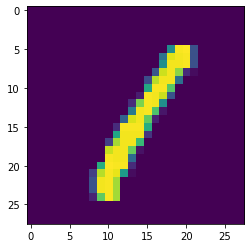

In [1]:
import struct
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import transforms

transformacija1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
#     transforms.CenterCrop(10),
])

class MnistDataset(Dataset):
    def __init__(self, path, transform=None):
        self.data = None
        self.transform = transform
        self._load(path)
    
    def load_labels(self, path):
        with open(path, "rb") as fp:
            struct.unpack(">I", fp.read(4))
            number_of_labels = struct.unpack(">I", fp.read(4))[0]
            labels = torch.tensor(np.frombuffer(fp.read(number_of_labels), dtype=np.uint8), dtype=torch.long)
            return labels

    def load_images(self, path):
        with open(path, "rb") as fp:
            struct.unpack(">I", fp.read(4))
            number_of_images = struct.unpack(">I", fp.read(4))[0]
            rows = struct.unpack(">I", fp.read(4))[0]
            cols = struct.unpack(">I", fp.read(4))[0]
            images = (np.frombuffer(fp.read(number_of_images*rows*cols), dtype=np.uint8).reshape((number_of_images, rows, cols)))
            return images
    
    def _load(self, path):
        labels = self.load_labels(path + "-labels.idx1-ubyte")
        images = self.load_images(path + "-images.idx3-ubyte")
        self.data = list(zip(images, labels))
    
    def __getitem__(self, index):
        if self.transform is not None:
            return (self.transform(self.data[index][0]), self.data[index][1])
        
        return self.data[index]
    
    def __len__(self):
        return len(self.data)

train_dataset = MnistDataset("train", transformacija1)
test_dataset = MnistDataset("t10k", transformacija1)
print(len(train_dataset))
print(len(test_dataset))
print(train_dataset[10][0].shape)

import matplotlib.pyplot as plt
train_dataset[11][0].numpy()
print(np.random.random((1, 300, 300)).shape)
plt.imshow(train_dataset[3][0].numpy().reshape(28, 28, 1))

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()
print(model)
X, y = train_dataset[10]
print(model(X))
print(y)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
    (7): ReLU()
  )
)
tensor([[0.0403, 0.0412, 0.0000, 0.0173, 0.0111, 0.1040, 0.0525, 0.0000, 0.0002,
         0.0527]], grad_fn=<ReluBackward0>)
tensor(3)


In [3]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [4]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=60)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=60)
            
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.307896  [    0/60000]
loss: 2.259304  [ 6000/60000]
loss: 2.174999  [12000/60000]
loss: 1.967994  [18000/60000]
loss: 1.625780  [24000/60000]
loss: 1.259990  [30000/60000]
loss: 1.106791  [36000/60000]
loss: 1.093559  [42000/60000]
loss: 0.995852  [48000/60000]
loss: 1.158416  [54000/60000]
Test Error: 
 Accuracy: 75.2%, Avg loss: 0.014638 

Epoch 2
-------------------------------
loss: 0.731635  [    0/60000]
loss: 0.688875  [ 6000/60000]
loss: 0.662596  [12000/60000]
loss: 0.881718  [18000/60000]
loss: 0.721223  [24000/60000]
loss: 0.619501  [30000/60000]
loss: 0.824246  [36000/60000]
loss: 0.562481  [42000/60000]
loss: 0.732412  [48000/60000]
loss: 0.522099  [54000/60000]
Test Error: 
 Accuracy: 81.3%, Avg loss: 0.009406 

Epoch 3
-------------------------------
loss: 0.426279  [    0/60000]
loss: 0.653092  [ 6000/60000]
loss: 0.654473  [12000/60000]
loss: 0.396374  [18000/60000]
loss: 0.830370  [24000/60000]
loss: 0.517914  [30000/600

# Zadatak 2
Napraviti konvolutivnu neuronsku mrežu za klasifikaciju podataka iz MNIST skupa podataka.

In [ ]:
class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Conv2d(1, 6, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(6, 16, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(400, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

net = ConvNeuralNetwork()
print(net)
    
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=50)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=50)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, net, loss_fn, optimizer)
    test_loop(test_dataloader, net, loss_fn)
print("Done!")

ConvNeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=512, bias=True)
    (10): ReLU()
    (11): Linear(in_features=512, out_features=512, bias=True)
    (12): ReLU()
    (13): Linear(in_features=512, out_features=10, bias=True)
    (14): ReLU()
  )
)
Epoch 1
-------------------------------
loss: 2.301950  [    0/60000]
loss: 2.301245  [ 5000/60000]
loss: 2.300263  [10000/60000]
loss: 2.298600  [15000/60000]
loss: 2.303131  [20000/60000]
loss: 2.301063  [25000/60000]
loss: 2.304560  [30000/60000]
loss: 2.301193  [

# Zadatak 3
Uporediti rezultate potpuno povezane i konvolutivne neuronske mreže.